<a href="https://colab.research.google.com/github/AbigailMRod/GANsDL.AI/blob/main/ControllableGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación Controlable

En este cuaderno, se implementará un método para controlar una GAN mediante gradientes de un clasificador. Al entrenar un clasificador para que reconozca una característica relevante, puede usarlo para cambiar las entradas del generador (vectores z) para que genere imágenes con más o menos de esa característica.

Comenzaremos con un generador y un clasificador pre-entrenados, para que pueda concentrarse en los aspectos de control. Sin embargo, en caso de que se desee entrenar clasificador propio, también se ha proporcionado el código para ello.



## ¡Empezando!

Comenzaremos importando bibliotecas y paquetes útiles y definiendo una función de visualización. El clasificador tiene la misma arquitectura que el crítico anterior (recuerde que el discriminador/crítico es simplemente un clasificador utilizado para clasificar lo real y lo falso).

#### CelebA
Para este cuaderno, en lugar del conjunto de datos MNIST, utilizaremos [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). CelebA es un conjunto de datos de imágenes de celebridades comentadas. Dado que son de color (no en blanco y negro), las imágenes tienen tres canales para rojo, verde y azul (RGB).
<img src="http://mmlab.ie.cuhk.edu.hk/projects/CelebA/overview.png">

####Paquetes y Visualización

In [11]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### Generador y Ruido

In [12]:
class Generator(nn.Module):
    '''
    Clase de generador
     Valores:
         z_dim: la dimensión del vector de ruido, un escalar
         im_chan: el número de canales en las imágenes, ajustado para el conjunto de datos utilizado, un escalar
               (CelebA es rgb, por lo que 3 es nuestro valor predeterminado)
         hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Construcción de la red neuronal
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque generador de DCGAN;
         una convolución transpuesta, una norma por lotes (excepto en la capa final) y una activación.
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Función para completar un paso hacia adelante del generador: Dado un tensor de ruido,
         devuelve las imágenes generadas.
         Parámetros:
             noise: un tensor de ruido con dimensiones (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Función para crear vectores de ruido: Dadas las dimensiones (n_samples, z_dim)
     crea un tensor de esa forma lleno de números aleatorios de la distribución normal.
     Parámetros:
         n_samples: el número de muestras en el lote, un escalar
         z_dim: la dimensión del vector de ruido, un escalar
         device: el tipo de dispositivoe
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Clasificador

In [13]:
class Classifier(nn.Module):
    '''
    Clase de clasificador
     Valores:
         im_chan: el número de canales en las imágenes, ajustado para el conjunto de datos utilizado, un escalar
               (CelebA es rgb, por lo que 3 es nuestro valor predeterminado)
         n_classes: el número total de clases en el conjunto de datos, un escalar entero
         hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque clasificador;
         una convolución, una norma por lotes (excepto en la capa final) y una activación (excepto en la capa final).
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Función para completar un pase hacia adelante del clasificador: Dado un tensor de imagen,
         devuelve un tensor n_classes-dimension que representa falso/real.
         Parámetros:
             image: un tensor de imagen aplanado con canales im_chan
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

## Especificación de parámetros
Antes de comenzar a entrenar, debe especificar algunos parámetros:
   * z_dim: la dimensión del vector de ruido
   * batch_lote: el número de imágenes por paso adelante/atrás
   * device: el tipo de dispositivo

In [14]:
z_dim = 64
batch_size = 128
device = 'cpu'

## Entrenar a un Clasificador (Opcional)

Se puede entrenar un clasificardor propio con este código, pero se le proporciona uno previamente entrenado más adelante en el código. Siéntase libre de omitir este bloque de código, y si desea entrenar su propio clasificador, se recomienda que primero realice la tarea con el clasificador proporcionado.

In [ ]:
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Puede ejecutar este código para entrenar su propio clasificador, pero se proporciona uno preentrenado.
     # Si desea usar esto, simplemente ejecute "train_classifier(filename)" para entrenar y guardar 
     # un clasificador en los índices de etiquetas para ese nombre de archivo.

    # Diríjase a todas las clases, de modo que esa sea la cantidad que aprenderá el clasificador
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader devuelve los lotes
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calcula los gradientes
            class_opt.step() # Actualiza los pesos
            classifier_losses += [class_loss.item()] # Mantenga un registro de la pérdida promedio del clasificador

            ## Visualización del código ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Epoch {epoch}, step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Descomente la última línea para entrenar a su propio clasificador;
# Si desea hacer esto, deberá descargarlo y ejecutarlo, idealmente usando una GPU
# train_classifier("nombre de archivo")

## Cargando los modelos preentrenados
A continuación, cargará el generador y el clasificador previamente entrenados mediante el siguiente código. (Si entrenó su propio clasificador, puede cargarlo aquí en su lugar).

Clonar repositorio para obtener models

In [18]:
!git clone https://github.com/AbigailMRod/GANsDL.AI.git

Cloning into 'GANsDL.AI'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 6), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [21]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("/content/GANsDL.AI/models/pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("/content/GANsDL.AI/models/pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


## Entrenamiento
¡Ahora puede comenzar a implementar un método para controlar su GAN!

#### Actualizar ruido
Para el entrenamiento, debe escribir el código para actualizar el ruido para producir más de la característica deseada. Para ello, realiza un ascenso de gradiente estocástico. Utiliza el ascenso de gradiente estocástico para encontrar los máximos locales, a diferencia del descenso de gradiente estocástico que encuentra los mínimos locales. El ascenso de gradiente es el descenso de gradiente sobre el valor negativo que se está optimizando. Sus fórmulas son esencialmente las mismas, sin embargo, en lugar de restar el valor ponderado, el ascenso de gradiente estocástico lo suma; se puede calcular por `new = old + (∇ old * weight)`, donde ∇ es el gradiente de `viejo`. Realiza un ascenso de gradiente estocástico para intentar maximizar la cantidad de la función que desea. Si quisiera reducir la cantidad de la función, realizaría un descenso de gradiente. Sin embargo, en esta tarea, le interesa maximizar su característica mediante el ascenso de gradiente, ya que muchas características en el conjunto de datos no están presentes con mucha más frecuencia de lo que están presentes y está tratando de agregar una característica a las imágenes, no eliminarla.

Dado el ruido con su gradiente ya calculado a través del clasificador, desea devolver el nuevo vector de ruido.

<details>

<summary>
<font size="3" color="green">
<b>Consejo opcional para <code><font size="4">calculate_updated_noise</font></code></b>
</font>
</summary>

1.   Recuerde la ecuación para el ascenso de gradiente: `new = old + (∇ old * weight)`.

</details>

In [22]:
def calculate_updated_noise(noise, weight):
    '''
    Función para devolver vectores de ruido actualizados con ascenso de gradiente estocástico.
     Parámetros:
         noise: los vectores de ruido actuales. Ya ha llamado a la función de retroceso en la clase de destino
           para que pueda acceder al gradiente de la clase de salida con respecto al ruido usando noise.grad
         weight: la cantidad escalar por la que debe ponderar el gradiente de ruido
    '''
    #### START CODE HERE ####
    new_noise = noise + noise.grad*weight
    #### END CODE HERE ####
    return new_noise

In [23]:
# Prueba unitaria
opt.zero_grad()
noise = torch.ones(20, 20) * 2
noise.requires_grad_()
fake_classes = (noise ** 2).mean()
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1)
assert type(new_noise) == torch.Tensor
assert tuple(new_noise.shape) == (20, 20)
assert new_noise.max() == 2.0010
assert new_noise.min() == 2.0010
assert torch.isclose(new_noise.sum(), torch.tensor(0.4) + 20 * 20 * 2)
print("Success!")

Success!


In [24]:
# Comprueba que funciona para las imágenes generadas
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_()
fake = gen(noise)
fake_classes = classifier(fake)[:, 0]
fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]
assert torch.all(fake_classes_new > fake_classes)
print("Success!")

Success!


#### Generación
Ahora, puede usar el clasificador junto con el ascenso de gradiente estocástico para hacer ruido que genere más de una determinada característica. En el código que se le proporciona aquí, puede generar caras sonrientes. ¡Siéntase libre de cambiar el índice de destino y controlar algunas de las otras funciones en la lista! Notará que algunas características son más fáciles de detectar y controlar que otras.

La lista que tiene aquí son las características etiquetadas en CelebA, que usó para entrenar su clasificador. Si quisiera controlar otra función, necesitaría obtener datos etiquetados con esa función y entrenar un clasificador en esa función.

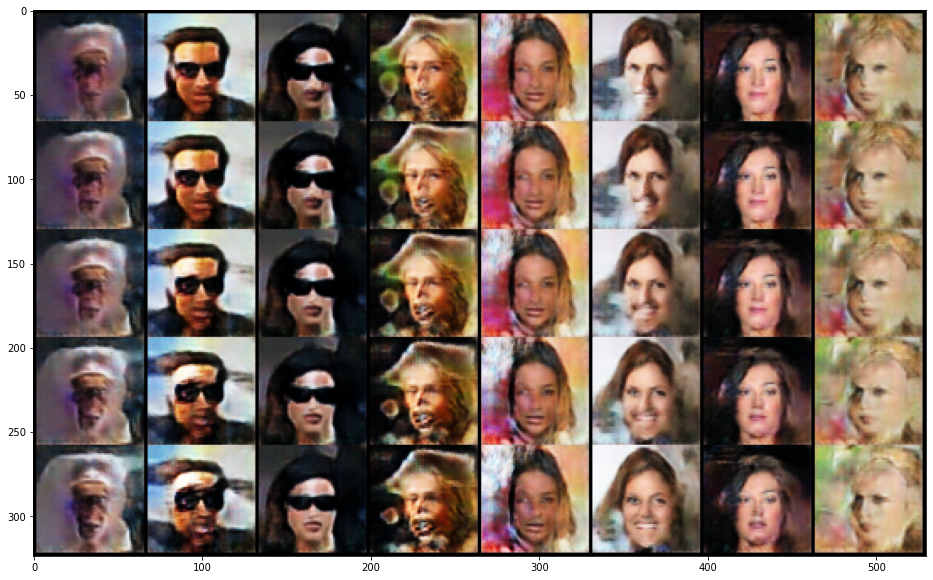

In [26]:
# Primero genera un montón de imágenes con el generador.
n_images = 8
fake_image_history = []
grad_steps = 10 # Número de pasos de gradiente a tomar
skip = 2 # Número de pasos de gradiente para omitir en la visualización

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("MouthSlightlyOpen") # ¡Siéntase libre de cambiar este valor a cualquier cadena de feature_names!

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

## Enredo y Regularización
También puede notar que a veces cambian más funciones además de la función de destino. Esto se debe a que algunas características están enredadas. Para solucionar esto, puede intentar aislar más la función de destino manteniendo constantes las clases fuera de la clase de destino. Una forma de implementar esto es penalizando las diferencias de la clase original con la regularización L2. Esta regularización L2 aplicaría una penalización por esta diferencia usando la norma L2 y esto sería solo un término adicional en la función de pérdida.

Aquí, tendrás que implementar la función de puntaje: cuanto más alto, mejor. La puntuación se calcula sumando la puntuación objetivo y una penalización; tenga en cuenta que la penalización está destinada a reducir la puntuación, por lo que debe tener un valor negativo.

Para cada clase no objetivo, tome la diferencia entre el ruido actual y el ruido antiguo. Cuanto mayor es este valor, más características fuera del objetivo han cambiado. Calcularás la magnitud del cambio, tomarás la media y la negarás. Finalmente, agregue esta penalización al puntaje objetivo. La puntuación objetivo es la media de la clase objetivo en el ruido actual.

In [27]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Función para devolver la puntuación de las clasificaciones actuales, penalizando cambios
     a otras clases con norma L2.
     Parámetros:
         current_classifications: las clasificaciones asociadas con el ruido actual
         original_classifications: las clasificaciones asociadas con el ruido original
         target_indices: el índice de la clase objetivo
         other_indices: los índices de las otras clases
         penalty_weight: la cantidad que la penalización debe ser ponderada en el puntaje general
    '''
    # Pasos: 1) Calcule el cambio entre las clasificaciones original y actual (como un tensor) indexando 
    #             los otros_índices que está tratando de conservar, como en x[:, características].
    #        2) Calcule la norma (magnitud) de los cambios por ejemplo.
    #        3) Multiplique la media de las normas de ejemplo por el peso de la penalización.
    #           Esta será tu other_class_penalty.
    #           ¡Asegúrate de que el valor sea negativo ya que es una penalización!
    #        4) Tome la media de las clasificaciones actuales para la característica de destino sobre todos los ejemplos.
    #           Esta media será su target_score.
    #### START CODE HERE ####
    # Calcular el error en other_indices    
    other_distances = current_classifications[:, other_indices] - original_classifications[:, other_indices]
    # Calcule la norma (magnitud) de los cambios por ejemplo y multiplíquela por el peso de la penalización 
    other_class_penalty = -torch.norm(other_distances, dim=1).mean() * penalty_weight
    # Tome la media de las clasificaciones actuales para la característica de destino  
    target_score = current_classifications[:, target_indices].mean()
    #### END CODE HERE ####
    return target_score + other_class_penalty

En el siguiente bloque de código, ejecutará el ascenso de gradiente con esta nueva función de puntuación. Es posible que note algunas cosas después de ejecutarlo:

1. Puede fallar más a menudo en la producción de la función de destino en comparación con el enfoque original. Esto sugiere que es posible que el modelo no pueda generar una imagen que tenga la característica de destino sin cambiar las otras características. ¡Esto tiene sentido! Por ejemplo, es posible que no pueda generar una cara que esté sonriendo pero cuya boca NO esté ligeramente abierta. Esto también puede exponer una limitación del generador.
Alternativamente, incluso si el generador puede producir una imagen con las características previstas, podría requerir muchos cambios intermedios para llegar allí y quedarse atascado en un mínimo local.

2. Este proceso puede cambiar características que el clasificador no fue entrenado para reconocer ya que no hay forma de penalizarlas con este método. Si es posible entrenar modelos para evitar cambiar características no supervisadas es una pregunta abierta.

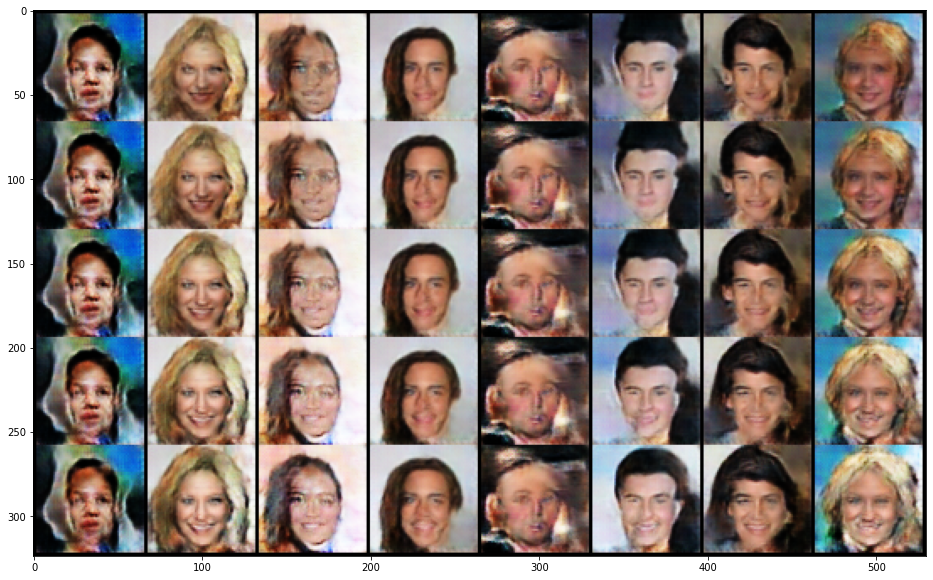

In [28]:
fake_image_history = []
### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)